# MIE524 - Assignment 5
Please complete this notebook for Assignment 5.

## Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Q1 - Neural Collaborative Filtering
[[paper]](https://arxiv.org/pdf/1708.05031.pdf)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

### Data
The MovieLens dataset (ml-latest-small) describes 5-star rating and free-text tagging activity from MovieLens, a movie recommendation service. It contains 100004 ratings and 1296 tag applications across 9125 movies.

In [ ]:
data = pd.read_csv("q1-ratings.csv")

In [ ]:
data.head(5)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


### Encode Data

In [ ]:
# split train and validation before encoding
np.random.seed(3)
msk = np.random.rand(len(data)) < 0.8
train = data[msk].copy()
val = data[~msk].copy()

In [ ]:
# here is a handy function modified from fast.ai
def proc_col(col, train_col=None):
    """Encodes a pandas column with continuous ids.
    """
    if train_col is not None:
        uniq = train_col.unique()
    else:
        uniq = col.unique()
    name2idx = {o:i for i,o in enumerate(uniq)}
    return name2idx, np.array([name2idx.get(x, -1) for x in col]), len(uniq)

In [ ]:
def encode_data(df, train=None):
    """ Encodes rating data with continous user and movie ids.
    If train is provided, encodes df with the same encoding as train.
    """
    df = df.copy()
    for col_name in ["userId", "movieId"]:
        train_col = None
        if train is not None:
            train_col = train[col_name]
        _,col,_ = proc_col(df[col_name], train_col)
        df[col_name] = col
        df = df[df[col_name] >= 0]
    return df

In [ ]:
# encoding the train and validation data
df_train = encode_data(train)
df_val = encode_data(val, train)

### a) Evaluate model parameters for NCF-GMF

In [ ]:
class MF(nn.Module):
    def __init__(self, num_users, num_items, emb_size=100):
        super(MF, self).__init__()
        self.emb_size = emb_size
        self.hidden_size = 0
        self.user_emb = nn.Embedding(num_users, emb_size)
        self.item_emb = nn.Embedding(num_items, emb_size)
        self.user_emb.weight.data.uniform_(0, 0.05)
        self.item_emb.weight.data.uniform_(0, 0.05)

    def forward(self, u, v):
        u = self.user_emb(u)
        v = self.item_emb(v)
        return (u*v).sum(1)

In [ ]:
users = torch.LongTensor(df_train.userId.values)
items = torch.LongTensor(df_train.movieId.values)
users

tensor([  0,   0,   0,  ..., 609, 609, 609])

In [ ]:
num_users = len(users.unique())
num_items = len(items.unique())

model = MF(num_users, num_items, emb_size = 100)

In [ ]:
def evaluate(model, df):
    model.eval()
    users = torch.LongTensor(df.userId.values)
    items = torch.LongTensor(df.movieId.values)
    ratings = torch.FloatTensor(df.rating.values)
    y_pred = model(users, items)
    loss = F.mse_loss(y_pred,ratings)
    return loss.item()
def plot_loss(train_loss_record, val_loss_record):
    epochs = range(1, len(train_loss_record) + 1)

    plt.figure(figsize=(10, 6))

    plt.plot(epochs, train_loss_record, label='Training Loss', color='blue', marker='o')

    plt.plot(epochs, val_loss_record, label='Validation Loss', color='red', marker='x')

    plt.title('Training and Validation Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend()

    plt.grid(True)
    plt.show()
def get_model_path(model, epoch, lr, wd):
    model_path = f"model_emb{model.emb_size}_hid{model.hidden_size}_lr{lr}_wd{wd}_epoch{epoch}"
    return model_path
def train(model, num_epochs=10, lr = 0.01, wd = 0.0, print_loss=True, binary = False):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    model.train()
    if binary == False:
      users = torch.LongTensor(df_train.userId.values)
      items = torch.LongTensor(df_train.movieId.values)
      ratings = torch.FloatTensor(df_train.rating.values)
    else:
      users = torch.LongTensor(df_train_br.userId.values)
      items = torch.LongTensor(df_train_br.movieId.values)
      ratings = torch.FloatTensor(df_train_br.rating.values)

    train_loss_record = []
    val_loss_record = []
    for i in range(num_epochs):
        y_pred = model(users, items)
        loss = F.mse_loss(y_pred, ratings)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if binary == False:
            val_loss = evaluate(model, df_val)
        else:
            val_loss = evaluate(model, df_val_br)

        if print_loss == True:
            print(f"Epoch {i}, Training Loss: {loss.item():.3f}")
            print(f"Epoch {i}, Validation Loss: {val_loss:.3f}")
        train_loss_record.append(loss.item())
        val_loss_record.append(val_loss)
        model_path = get_model_path(model, i, lr, wd)
        torch.save(model.state_dict(), model_path)
    return train_loss_record, val_loss_record


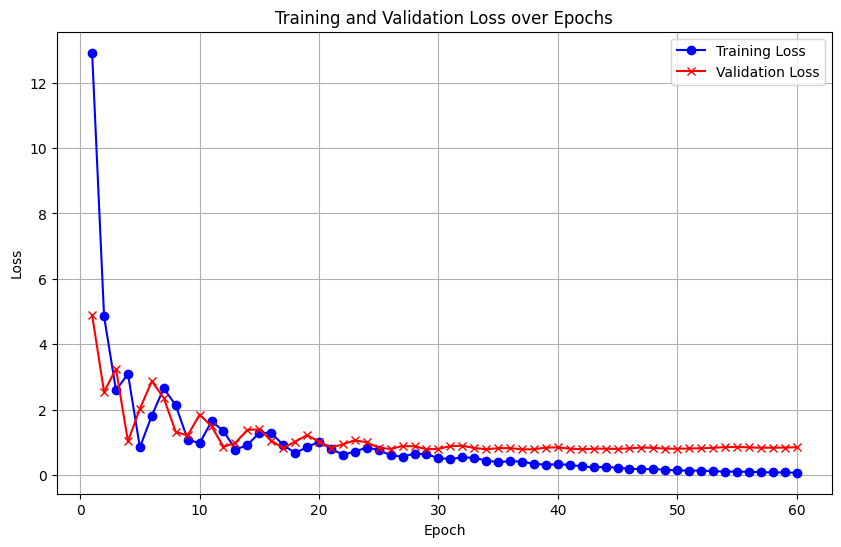

Minimum Validation loss: 0.786902129650116, at epoch 37


In [ ]:
model = MF(num_users, num_items, emb_size = 100)
train_loss_record, val_loss_record = train(model, lr = 0.1, num_epochs=60, print_loss=False)
plot_loss(train_loss_record, val_loss_record)
print(f"Minimum Validation loss: {min(val_loss_record)}, at epoch {np.argmin(val_loss_record)+1}")

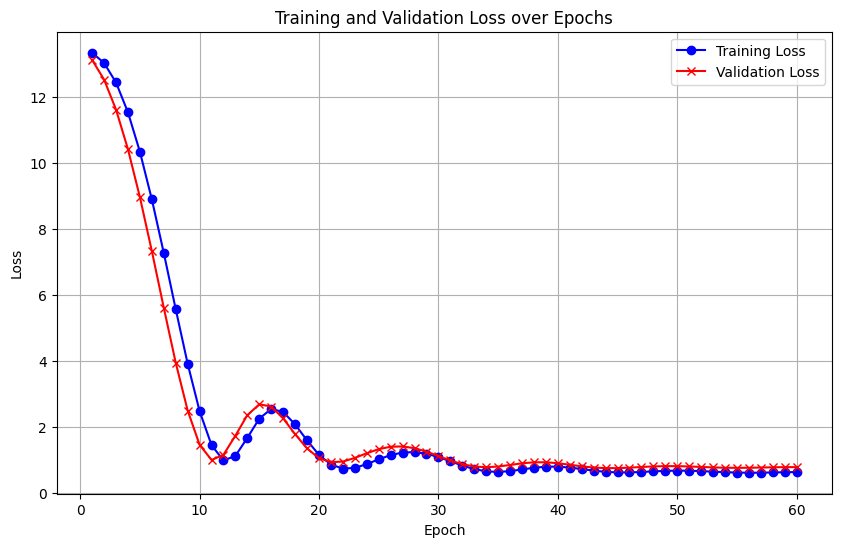

Minimum Validation loss: 0.7561777830123901, at epoch 44


In [ ]:
model = MF(num_users, num_items, emb_size = 3)
train_loss_record, val_loss_record = train(model, lr = 0.1, num_epochs=60, print_loss=False)
plot_loss(train_loss_record, val_loss_record)
print(f"Minimum Validation loss: {min(val_loss_record)}, at epoch {np.argmin(val_loss_record)+1}")

By decreasing embedding size, the model has less weights in Embedding, and is able to learn slower. This means that it will take more epochs to overfit.

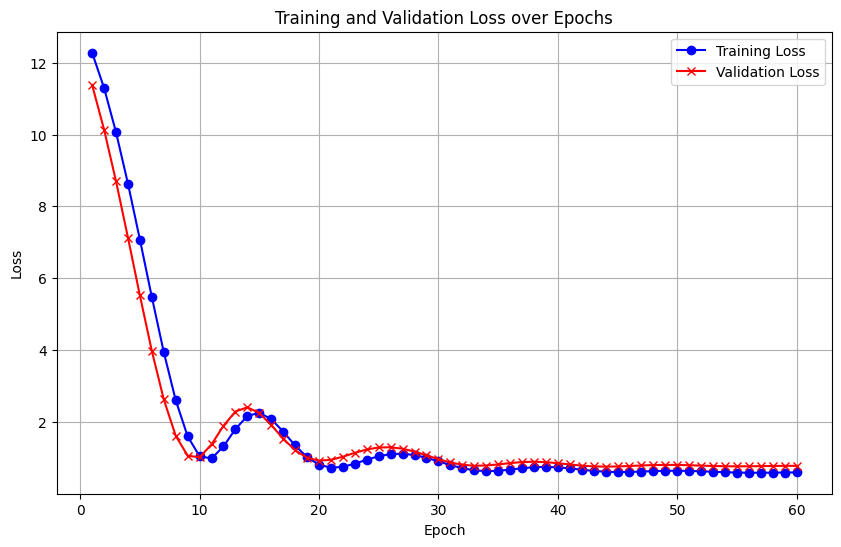

Minimum Validation loss: 0.7558959722518921, at epoch 44


In [ ]:
model = MF(num_users, num_items, emb_size = 250)
train_loss_record, val_loss_record = train(model, lr = 0.01, num_epochs=60, print_loss=False)
plot_loss(train_loss_record, val_loss_record)
print(f"Minimum Validation loss: {min(val_loss_record)}, at epoch {np.argmin(val_loss_record)+1}")

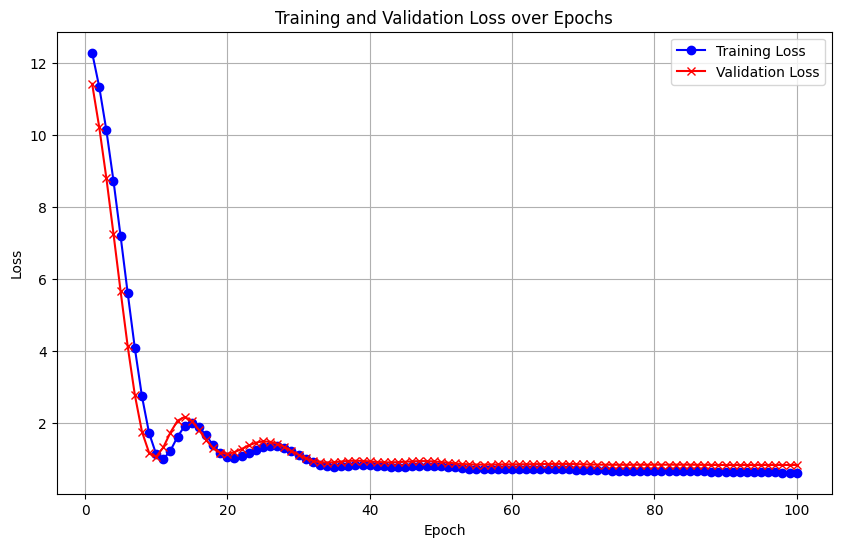

Minimum Validation loss: 0.8326675891876221, at epoch 92


In [ ]:
model = MF(num_users, num_items, emb_size = 250)
train_loss_record, val_loss_record = train(model, lr = 0.01, num_epochs=100, print_loss=False, wd = 0.0001)
plot_loss(train_loss_record, val_loss_record)
print(f"Minimum Validation loss: {min(val_loss_record)}, at epoch {np.argmin(val_loss_record)+1}")

Weight decay penalizes high weights, allowing model to learn and overfit slower.

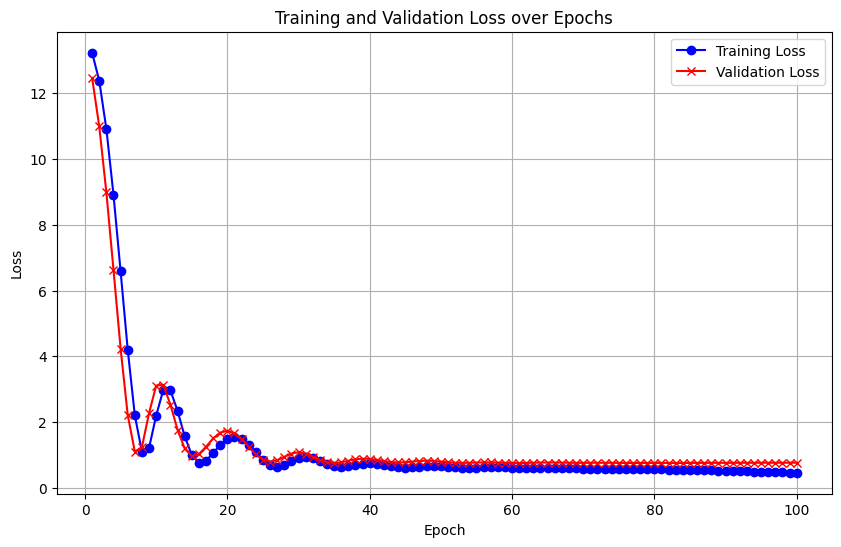

Minimum Validation loss: 0.7545315623283386, at epoch 61


In [ ]:
model = MF(num_users, num_items, emb_size = 25)
train_loss_record, val_loss_record = train(model, lr = 0.05, num_epochs=100, print_loss=False)
plot_loss(train_loss_record, val_loss_record)
print(f"Minimum Validation loss: {min(val_loss_record)}, at epoch {np.argmin(val_loss_record)+1}")

This model has the lowest validation loss, so this is our best model.

### b) NCF-MLP Model

<img src=https://miro.medium.com/v2/resize:fit:1400/format:webp/1*aP-Mx266ExwoWZPSdHtYpA.png width="600">


In [ ]:
class my_NCF_MLP(nn.Module):
    def __init__(self, num_users, num_items, emb_size=100, hidden_size=10):
        super(my_NCF_MLP, self).__init__()

        # YOUR CODE HERE
        self.emb_size = emb_size
        self.hidden_size = hidden_size

        self.user_emb = nn.Embedding(num_users, emb_size)
        self.item_emb = nn.Embedding(num_items, emb_size)
        self.user_emb.weight.data.uniform_(0, 0.05)
        self.item_emb.weight.data.uniform_(0, 0.05)
        self.fc1 = nn.Linear(emb_size*2, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, u, v):

        # YOUR CODE HERE
        u = self.user_emb(u)
        v = self.item_emb(v)
        c = torch.cat((u, v), dim=1)
        c = F.relu(self.fc1(c))
        c = (torch.sigmoid(self.fc2(c))) * 5
        return c.squeeze(1)

Train model

Epoch 0, Training Loss: 1.829
Epoch 0, Validation Loss: 1.649
Epoch 1, Training Loss: 1.653
Epoch 1, Validation Loss: 1.486
Epoch 2, Training Loss: 1.491
Epoch 2, Validation Loss: 1.325
Epoch 3, Training Loss: 1.330
Epoch 3, Validation Loss: 1.169
Epoch 4, Training Loss: 1.171
Epoch 4, Validation Loss: 1.031
Epoch 5, Training Loss: 1.029
Epoch 5, Validation Loss: 0.932
Epoch 6, Training Loss: 0.923
Epoch 6, Validation Loss: 0.885
Epoch 7, Training Loss: 0.866
Epoch 7, Validation Loss: 0.880
Epoch 8, Training Loss: 0.850
Epoch 8, Validation Loss: 0.890
Epoch 9, Training Loss: 0.848
Epoch 9, Validation Loss: 0.891


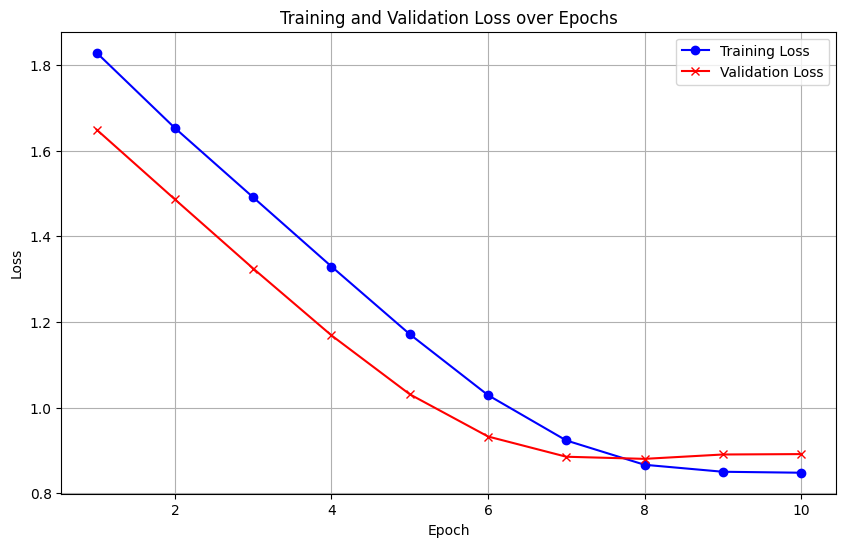

In [ ]:
# YOUR CODE HERE
model = my_NCF_MLP(num_users, num_items)
train_loss_record, val_loss_record = train(model,print_loss=True)
plot_loss(train_loss_record, val_loss_record)

### c) Evaluate model parameters for NCF-MLP

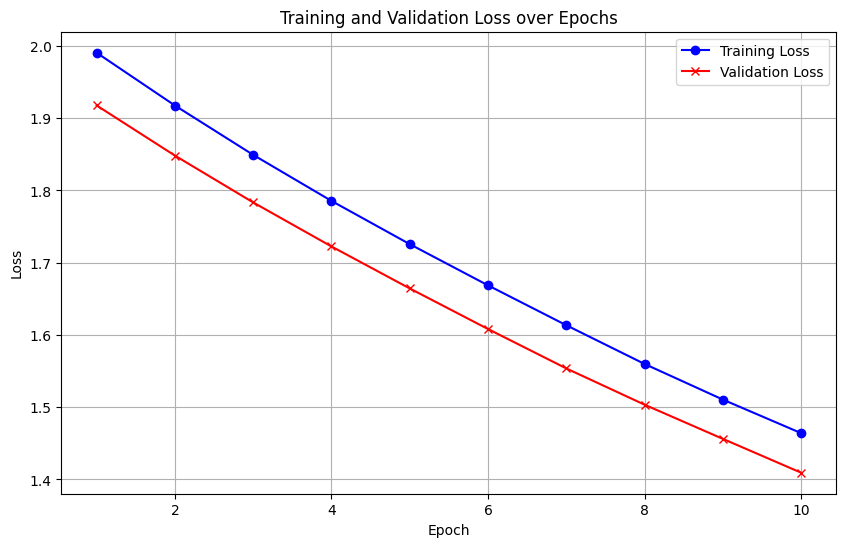

Minimum Validation loss: 1.4092400074005127, at epoch 10


In [ ]:
model = my_NCF_MLP(num_users, num_items,emb_size=3)
train_loss_record, val_loss_record = train(model,print_loss=False)
plot_loss(train_loss_record, val_loss_record)
print(f"Minimum Validation loss: {min(val_loss_record)}, at epoch {np.argmin(val_loss_record)+1}")

By decreasing embedding size, the model has less weights in Embedding, and is able to learn slower. This means that it will take more epochs to overfit.

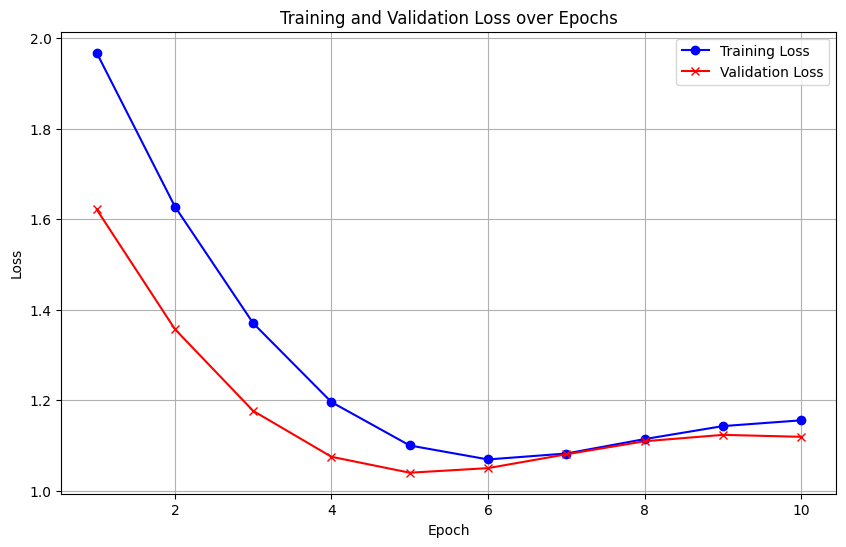

Minimum Validation loss: 1.0398578643798828, at epoch 5


In [ ]:
model = my_NCF_MLP(num_users, num_items,emb_size=3,hidden_size=128)
train_loss_record, val_loss_record = train(model,print_loss=False)
plot_loss(train_loss_record, val_loss_record)
print(f"Minimum Validation loss: {min(val_loss_record)}, at epoch {np.argmin(val_loss_record)+1}")

By increasing the hidden size, the model has more weights which allow it to learn and overfit faster.

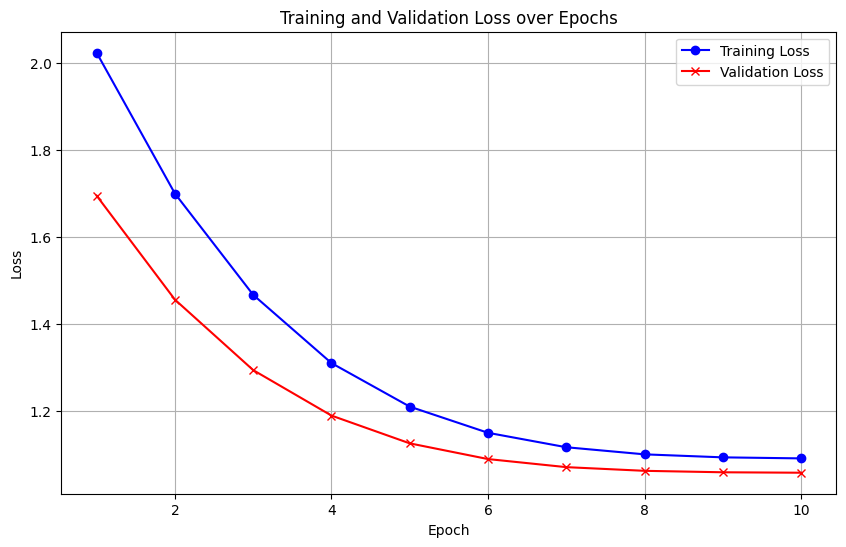

Minimum Validation loss: 1.0590989589691162, at epoch 10


In [ ]:
model = my_NCF_MLP(num_users, num_items,emb_size=3,hidden_size=128)
train_loss_record, val_loss_record = train(model,print_loss=False, wd=0.5)
plot_loss(train_loss_record, val_loss_record)
print(f"Minimum Validation loss: {min(val_loss_record)}, at epoch {np.argmin(val_loss_record)+1}")

Weight decay penalizes high weights, allowing model to learn and overfit slower.

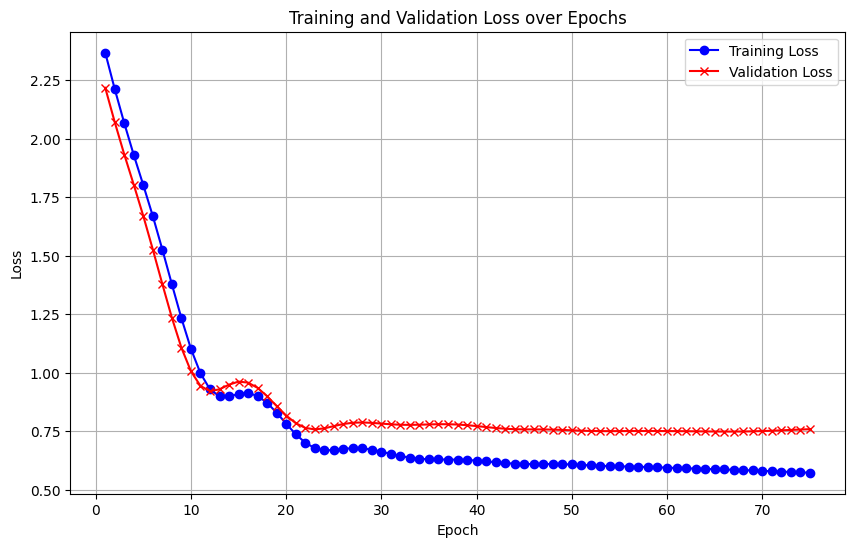

Minimum Validation loss: 0.7479693293571472, at epoch 66


In [ ]:
model = my_NCF_MLP(num_users, num_items, hidden_size=64,emb_size=50)
train_loss_record, val_loss_record = train(model,num_epochs = 75,print_loss=False,lr=0.005)
plot_loss(train_loss_record, val_loss_record)
print(f"Minimum Validation loss: {min(val_loss_record)}, at epoch {np.argmin(val_loss_record)+1}")

This model has the lowest validation loss, so this is our best model.

### d) Compare your best NCF-GMF and NCF-MLP

In [ ]:
# YOUR CODE HERE
GMF = MF(num_users, num_items, emb_size = 25)
model_path = get_model_path(GMF, 60, 0.05, 0.0)
state = torch.load(model_path)
GMF.load_state_dict(state)

MLP = my_NCF_MLP(num_users, num_items, hidden_size=64,emb_size=50)
model_path = get_model_path(MLP, 65, 0.005, 0.0)
state = torch.load(model_path)
MLP.load_state_dict(state)

<ipython-input-117-8508be2a5c86>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path)
<ipython-input-117-8508be2a5c86>:9: FutureWarning: You are u

<All keys matched successfully>

In [ ]:
print(f"Best GMF Validation Loss:{evaluate(GMF,df_val)}")
print(f"Best MLP Validation Loss:{evaluate(MLP,df_val)}")

Best GMF Validation Loss:0.7545315623283386
Best MLP Validation Loss:0.7479693293571472


Written comments: The MLP is able to outperform GMF based on validation loss. The interaction between users and items for GMF is based on a simple linear combination of multiplication of latent features, while MLP is able to model more complex interaction. This might lead to better performance.

### e) Change ratings to 1 or 0.

In [ ]:
# YOUR CODE HERE
df_train_br = df_train.copy()
df_val_br = df_val.copy()
df_train_br['rating'] = df_train_br['rating'].apply(lambda x: 1 if x >= 3 else 0)
df_val_br['rating'] = df_val_br['rating'].apply(lambda x: 1 if x >= 3 else 0)
df_train_br.head(5)

,userId,movieId,rating,timestamp
0,0,0,1,964982703
1,0,1,1,964981247
2,0,2,1,964982224
3,0,3,1,964983815
6,0,4,1,964980868


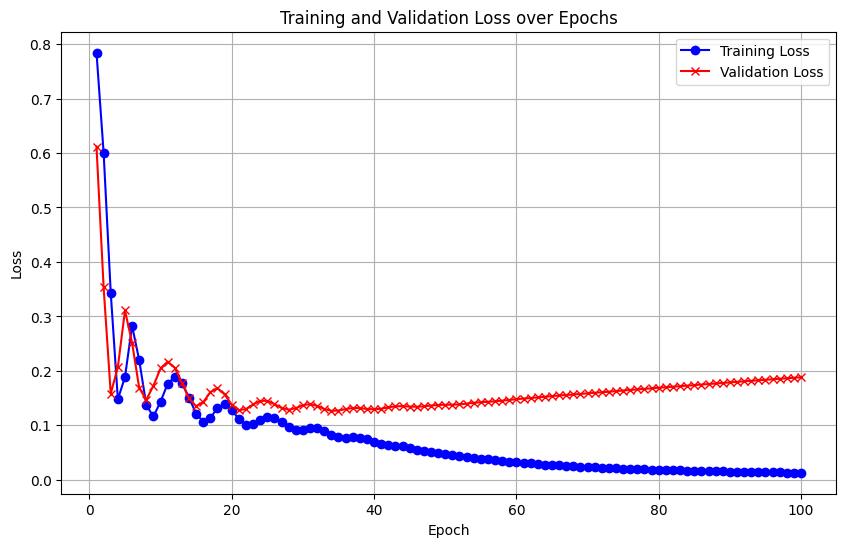

Minimum Validation loss: 0.12661483883857727, at epoch 34


In [ ]:
model_GMF = MF(num_users, num_items, emb_size = 25)
train_loss_record, val_loss_record = train(model_GMF, lr = 0.05, num_epochs=100, print_loss=False, binary = True)
plot_loss(train_loss_record, val_loss_record)
print(f"Minimum Validation loss: {min(val_loss_record)}, at epoch {np.argmin(val_loss_record)+1}")

In [ ]:
#The model should use sigmoid * 1
class my_NCF_MLP(nn.Module):
    def __init__(self, num_users, num_items, emb_size=100, hidden_size=10):
        super(my_NCF_MLP, self).__init__()

        # YOUR CODE HERE
        self.emb_size = emb_size
        self.hidden_size = hidden_size

        self.user_emb = nn.Embedding(num_users, emb_size)
        self.item_emb = nn.Embedding(num_items, emb_size)
        self.user_emb.weight.data.uniform_(0, 0.05)
        self.item_emb.weight.data.uniform_(0, 0.05)
        self.fc1 = nn.Linear(emb_size*2, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, u, v):

        # YOUR CODE HERE
        u = self.user_emb(u)
        v = self.item_emb(v)
        c = torch.cat((u, v), dim=1)
        c = F.relu(self.fc1(c))
        c = (torch.sigmoid(self.fc2(c))) * 1
        return c.squeeze(1)

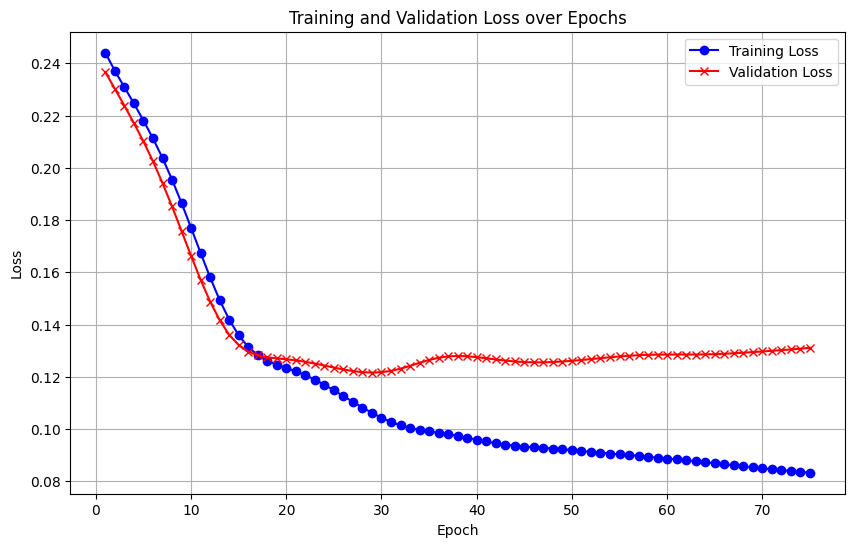

Minimum Validation loss: 0.1216229796409607, at epoch 29


In [ ]:
model_MLP = my_NCF_MLP(num_users, num_items, hidden_size=64,emb_size=50)
train_loss_record, val_loss_record = train(model_MLP,num_epochs = 75,print_loss=False,lr=0.005, binary=True)
plot_loss(train_loss_record, val_loss_record)
print(f"Minimum Validation loss: {min(val_loss_record)}, at epoch {np.argmin(val_loss_record)+1}")

In [ ]:
# Loading best model
GMF = MF(num_users, num_items, emb_size = 25)
model_path = get_model_path(GMF, 33, 0.05, 0.0)
state = torch.load(model_path)
GMF.load_state_dict(state)

MLP = my_NCF_MLP(num_users, num_items, hidden_size=64,emb_size=50)
model_path = get_model_path(MLP, 28, 0.005, 0.0)
state = torch.load(model_path)
MLP.load_state_dict(state)

<ipython-input-26-f26f1a8252d5>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path)
<ipython-input-26-f26f1a8252d5>:9: FutureWarning: You are usi

<All keys matched successfully>

In [ ]:
print(f"Best GMF Validation Loss:{evaluate(GMF,df_val_br)}")
print(f"Best MLP Validation Loss:{evaluate(MLP,df_val_br)}")

Best GMF Validation Loss:0.12661483883857727
Best MLP Validation Loss:0.1216229796409607


Written answer: There is a decrease in validation loss for both of the model from around 0.75 to 0.12. This is expected as the new binary dataset simplifies the problem. To conform with this new dataset, I would change my loss function from MSE to binary cross entropy loss. I would also change my_NCF_MLP model to have an output of range 0 to 1 instead of 0 to 5, which I had already done. Finally, we could change the evaluation metrics to be accuracy instead of loss.

### f) Hyperparameter tuning with ALS

In [ ]:
import pyspark
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
from pyspark import SparkContext, SparkConf

In [ ]:
# YOUR CODE HERE
conf = SparkConf()

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = pyspark.sql.SparkSession.builder.getOrCreate()

In [ ]:
spark_train = spark.createDataFrame(df_train)
spark_val = spark.createDataFrame(df_val)

In [ ]:
als = ALS(maxIter=10, rank=10, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop")
model = als.fit(spark_train)


In [ ]:
def evaluate_ALS(model):
    #Training
    predictions = model.transform(spark_train)
    evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                    predictionCol="prediction")
    rmse = evaluator.evaluate(predictions)
    print("Training Root-mean-square error = " + str(rmse))
    #Validation
    predictions = model.transform(spark_val)
    evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                    predictionCol="prediction")
    rmse = evaluator.evaluate(predictions)
    print("Validation Root-mean-square error = " + str(rmse))

In [ ]:
evaluate_ALS(model)

Training Root-mean-square error = 0.4703493137523804
Validation Root-mean-square error = 1.1116276266731953


In [ ]:
#Due to a very low training RMSE, and a very high validation RMSE. The model seems to be overfitting.
#So, I will decrease maxIter, and increase regParam.
als = ALS(maxIter=5, rank=10, regParam=0.1, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop")
model = als.fit(spark_train)
evaluate_ALS(model)

Training Root-mean-square error = 0.5861537379021936
Validation Root-mean-square error = 0.8850595869327686


In [ ]:
#The RMSE values between training and validation are now closer to each other; however,
#Training RMSE is still quite lower than Validation RMSE; so, I will reduce rank to prevent a little bit more overfitting.
als = ALS(maxIter=5, rank=3, regParam=0.1, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop")
model = als.fit(spark_train)
evaluate_ALS(model)

Training Root-mean-square error = 0.7094891781073634
Validation Root-mean-square error = 0.8885388570140389


In [ ]:
#The Validation RMSE isn't going down; so, I will try a new set of hyperparameters.
als = ALS(maxIter=5, rank=50, regParam=0.1, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop")
model = als.fit(spark_train)
evaluate_ALS(model)

Training Root-mean-square error = 0.467450834785598
Validation Root-mean-square error = 0.8754708001863459


In [ ]:
#This is the best validation RMSE we have ever achieved with room for improvement, because
#it is still overfitting; I'll increase regParam to add more regularization.
als = ALS(maxIter=5, rank=50, regParam=0.5, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop")
model = als.fit(spark_train)
evaluate_ALS(model)

Training Root-mean-square error = 0.9326862726377908
Validation Root-mean-square error = 1.0030650945250947


In [ ]:
#Too much regularization causes the model to underfit. I'll add maxIter and lower regParam to include
#more complexity.
als = ALS(maxIter=20, rank=50, regParam=0.2, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop")
model = als.fit(spark_train)
evaluate_ALS(model)

Training Root-mean-square error = 0.6930887889166708
Validation Root-mean-square error = 0.8727629651316166


In [ ]:
#A little bit of overfitting is left. I'll lower rank by only a little to try to achieve a tiny better performance.
als = ALS(maxIter=20, rank=20, regParam=0.2, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop")
model = als.fit(spark_train)
evaluate_ALS(model)

Training Root-mean-square error = 0.6952427557493984
Validation Root-mean-square error = 0.8727073952338933


In [ ]:
#The last combination is our best model.

## Q2 - Zero-Shot Text Classification
https://huggingface.co/tasks/zero-shot-classification

In [ ]:
!pip install transformers
!pip install datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
from transformers import pipeline
from datasets import Dataset

### Data

In [ ]:
arxiv_data = pd.read_csv('q2-arxiv-metadata-oai-snapshot-small.csv', index_col = 0)
# find smallest category
min_samples_per_category = arxiv_data['first_category_english'].value_counts().min()
# make new df to store balanced data sample
balanced_sample = pd.DataFrame()
# go thru category and add random sample to new df
for category, group in arxiv_data.groupby('first_category_english'):
    balanced_sample = pd.concat([balanced_sample, group.sample(min_samples_per_category, random_state=42)])
print(f'Size of downsampled data: {len(balanced_sample)}')
# convert to huggingface dataset for faster processing
balanced_sample = Dataset.from_pandas(balanced_sample)

Size of downsampled data: 999


### a) Precict categories and compute performance

In [ ]:
categories = list(set(balanced_sample["first_category_english"]))
categories

['Software Engineering',
 'Emerging Technologies',
 'Numerical Analysis',
 'Computers and Society',
 'Computer Science and Game Theory',
 'Discrete Mathematics',
 'Computer Vision and Pattern Recognition',
 'Robotics',
 'Symbolic Computation',
 'Other Computer Science',
 'Information Retrieval',
 'Data Structures and Algorithms',
 'Artificial Intelligence',
 'Human-Computer Interaction',
 'Mathematical Software',
 'Databases',
 'Neural and Evolutionary Computing',
 'Information Theory',
 'Programming Languages',
 'Distributed, Parallel, and Cluster Computing',
 'Machine Learning',
 'Computation and Language',
 'Formal Languages and Automata Theory',
 'Cryptography and Security',
 'Social and Information Networks',
 'Computational Engineering, Finance, and Science',
 'Computational Complexity']

In [ ]:
sorted(categories)

['Artificial Intelligence',
 'Computation and Language',
 'Computational Complexity',
 'Computational Engineering, Finance, and Science',
 'Computer Science and Game Theory',
 'Computer Vision and Pattern Recognition',
 'Computers and Society',
 'Cryptography and Security',
 'Data Structures and Algorithms',
 'Databases',
 'Discrete Mathematics',
 'Distributed, Parallel, and Cluster Computing',
 'Emerging Technologies',
 'Formal Languages and Automata Theory',
 'Human-Computer Interaction',
 'Information Retrieval',
 'Information Theory',
 'Machine Learning',
 'Mathematical Software',
 'Neural and Evolutionary Computing',
 'Numerical Analysis',
 'Other Computer Science',
 'Programming Languages',
 'Robotics',
 'Social and Information Networks',
 'Software Engineering',
 'Symbolic Computation']

In [ ]:
# YOUR CODE HERE
device = 0 if torch.cuda.is_available() else -1
pipe = pipeline(model="facebook/bart-large-mnli", device=device)
def classify_title(batch, col_name='first_cat_pred'):
    result = pipe(batch['title'], candidate_labels=categories)
    batch[col_name] = result['labels'][0]
    return batch  # Return the label with the highest score


In [ ]:
balanced_sample = balanced_sample.map(classify_title)

In [ ]:
label_mapping = {}
for i,cat in enumerate(categories):
    label_mapping[cat] = i
print(label_mapping)

{'Software Engineering': 0, 'Emerging Technologies': 1, 'Numerical Analysis': 2, 'Computers and Society': 3, 'Computer Science and Game Theory': 4, 'Discrete Mathematics': 5, 'Computer Vision and Pattern Recognition': 6, 'Robotics': 7, 'Symbolic Computation': 8, 'Other Computer Science': 9, 'Information Retrieval': 10, 'Data Structures and Algorithms': 11, 'Artificial Intelligence': 12, 'Human-Computer Interaction': 13, 'Mathematical Software': 14, 'Databases': 15, 'Neural and Evolutionary Computing': 16, 'Information Theory': 17, 'Programming Languages': 18, 'Distributed, Parallel, and Cluster Computing': 19, 'Machine Learning': 20, 'Computation and Language': 21, 'Formal Languages and Automata Theory': 22, 'Cryptography and Security': 23, 'Social and Information Networks': 24, 'Computational Engineering, Finance, and Science': 25, 'Computational Complexity': 26}


In [ ]:
balanced_sample = balanced_sample.map(lambda x: {'first_category_english': label_mapping[x['first_category_english']]})
balanced_sample = balanced_sample.map(lambda x: {'first_cat_pred': label_mapping[x['first_cat_pred']]})


Map:   0%|          | 0/999 [00:00<?, ? examples/s]

Map:   0%|          | 0/999 [00:00<?, ? examples/s]

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
accuracy = accuracy_score(balanced_sample['first_category_english'], balanced_sample['first_cat_pred'])
f1 = f1_score(balanced_sample['first_category_english'], balanced_sample['first_cat_pred'], average='weighted')
print("Accuracy:", accuracy)
print("F1 score", f1)

Accuracy: 0.16516516516516516
F1 score 0.1575357945716523


### b) Poor performing categories

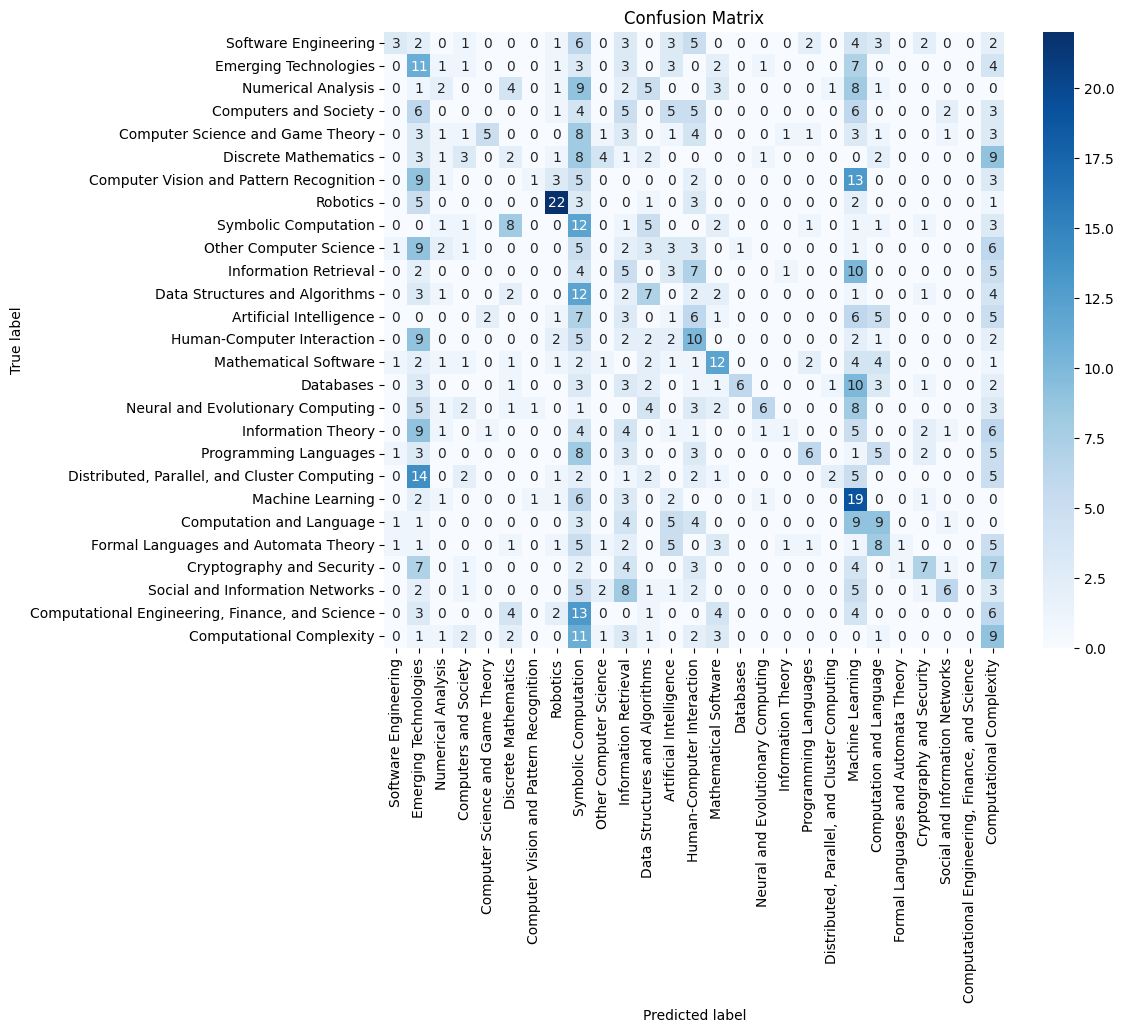

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# YOUR CODE HERE
cm = confusion_matrix(balanced_sample['first_category_english'], balanced_sample['first_cat_pred'])

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))

# Rotate the x-axis labels vertically
plt.xticks(rotation=90)

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')

plt.show()

Written answer: There are alot of categories that the Zero-Shot Learning framework perform poorly. However, these are the worst three categories which have zero correct classification: 'Computers and society', 'Other computer science', and 'Computational engineering, finance, and science'. The first reason  which leads to these poor performance might come from significant overlapping in terms of terminology and concepts between two categories, leading to very similar titles. As an example, Computational Engineering, Finance, and Science category contains a lot of symbolic calculations which might make the titles become very close to those of Symbolic Computation leading to misclassification of this category as Symbolic Computation seen from the confusion matrix. The second reason is that these categories might need a deeper understanding of the context than just the title to be able to classify them into the correct categories.


Methods to improve the performance:
1. Explore alternative pre-trained models that might be more suitable for this task.
2. Look at parts of the papers that might provide more information than title like abstracts.

### c) Evaluate different language models

In [ ]:
# YOUR CODE HERE
pipe = pipeline(task='zero-shot-classification', model='roberta-large-mnli', device=device)
balanced_sample = balanced_sample.map(classify_title,  fn_kwargs={'col_name': 'first_cat_pred_roberta'})


Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Map:   0%|          | 0/999 [00:00<?, ? examples/s]

In [ ]:
balanced_sample = balanced_sample.map(lambda x: {'first_cat_pred_roberta': label_mapping[x['first_cat_pred_roberta']]})
accuracy = accuracy_score(balanced_sample['first_category_english'], balanced_sample['first_cat_pred_roberta'])
f1 = f1_score(balanced_sample['first_category_english'], balanced_sample['first_cat_pred_roberta'], average='weighted')
print("Accuracy:", accuracy)
print("F1 score", f1)

Map:   0%|          | 0/999 [00:00<?, ? examples/s]

Accuracy: 0.17217217217217218
F1 score 0.16367470689761665


In [ ]:
pipe = pipeline(task='zero-shot-classification', model='microsoft/deberta-large-mnli', device=device)
balanced_sample = balanced_sample.map(classify_title,  fn_kwargs={'col_name': 'first_cat_pred_deberta'})


config.json:   0%|          | 0.00/729 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.62G [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

Map:   0%|          | 0/999 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
balanced_sample = balanced_sample.map(lambda x: {'first_cat_pred_deberta': label_mapping[x['first_cat_pred_deberta']]})
accuracy = accuracy_score(balanced_sample['first_category_english'], balanced_sample['first_cat_pred_deberta'])
f1 = f1_score(balanced_sample['first_category_english'], balanced_sample['first_cat_pred_deberta'], average='weighted')
print("Accuracy:", accuracy)
print("F1 score", f1)

Map:   0%|          | 0/999 [00:00<?, ? examples/s]

Accuracy: 0.1871871871871872
F1 score 0.1711411129751335


Written answer: There is a slight performance boost in both accuracy and F1 score for both of the new models compared to facebook/bart-large-mnli.

### d) Repear parts a) and b) with the abstracts

In [ ]:
# YOUR CODE HERE
pipe = pipeline(model="facebook/bart-large-mnli", device=device)
def classify_abstract(batch, col_name='first_cat_pred_abstract'):
    result = pipe(batch['abstract'], candidate_labels=categories)
    batch[col_name] = result['labels'][0]
    return batch  # Return the label with the highest score
balanced_sample = balanced_sample.map(classify_abstract)

Map:   0%|          | 0/999 [00:00<?, ? examples/s]

In [ ]:
balanced_sample = balanced_sample.map(lambda x: {'first_cat_pred_abstract': label_mapping[x['first_cat_pred_abstract']]})
accuracy = accuracy_score(balanced_sample['first_category_english'], balanced_sample['first_cat_pred_abstract'])
f1 = f1_score(balanced_sample['first_category_english'], balanced_sample['first_cat_pred_abstract'], average='weighted')

Map:   0%|          | 0/999 [00:00<?, ? examples/s]

In [ ]:
print("Accuracy:", accuracy)
print("F1 score", f1)

Accuracy: 0.15815815815815815
F1 score 0.16475209475760913


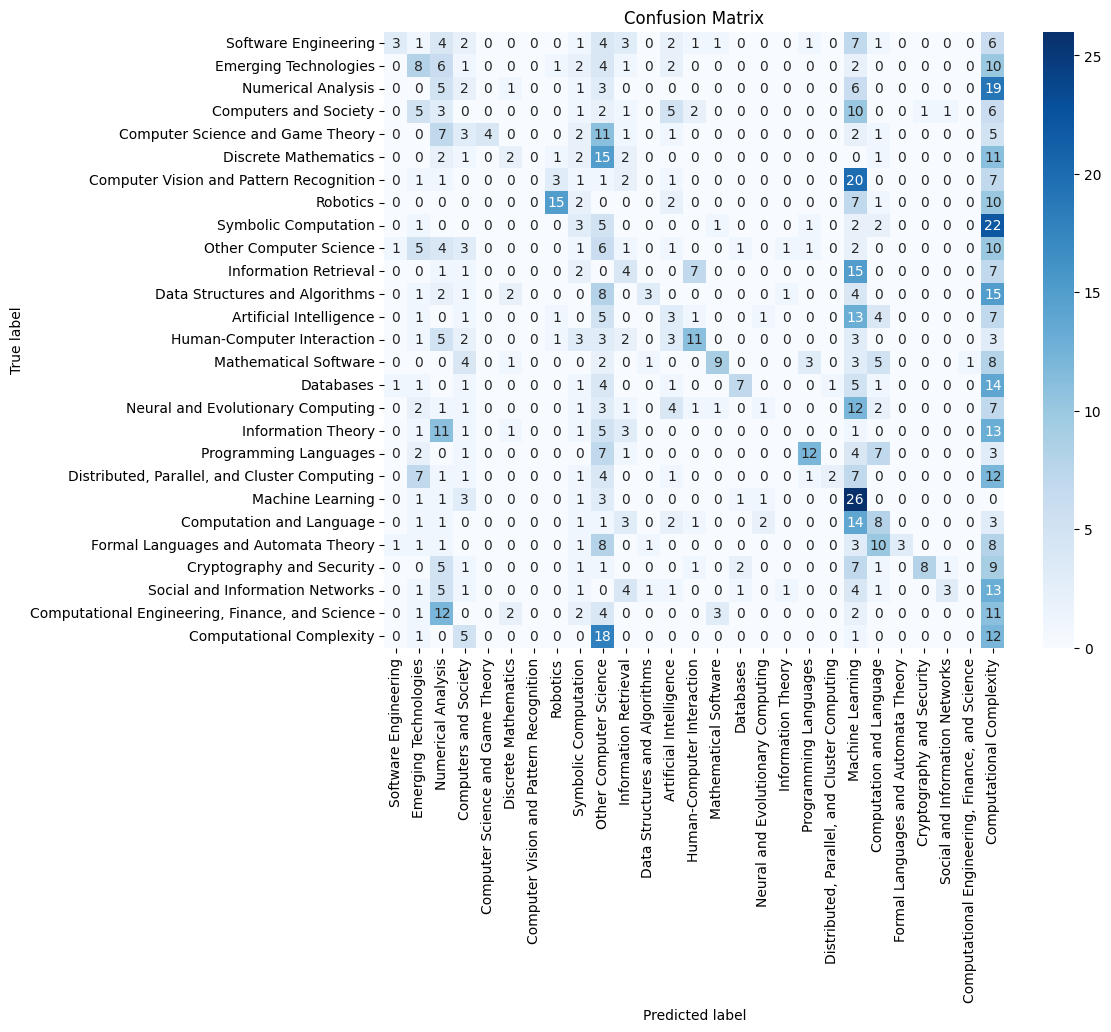

In [ ]:
cm = confusion_matrix(balanced_sample['first_category_english'], balanced_sample['first_cat_pred_abstract'])

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))

# Rotate the x-axis labels vertically
plt.xticks(rotation=90)

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')

plt.show()

Written asnwer:
The worst performing categories are now 'Computer and society', 'Computer Vision and Pattern Recognition', 'Information Theory', and 'Computational Engineering, Finance, and Science' with zero correct classification. The first reason which leads to the poor performance in these classes is the same as the first reason stated in part b). To clarify, categories closely related to each other will have similar context, leading to similar abstracts. This behavior can be seen from the misclassification of Computational Engineering, Finance, and Science as Numerical Analysis. The context of Computational Engineering, Finance, and Science contains alot of number which might lead to similar abstracts compared to Numerical Analysis, making it more difficult to differentiate between them. The second reason lies in the complexity of the abstract. The poor performance in Computers and society might comes from the fact that this abstract involves alot of complex concepts that are hard to understand with a generic text classification model.

Methods to improve the performance:
1. Explore alternative pre-trained models that might be more suitable for this task.
2. Include more metadata along with abstracts to provide more context.
3. Retrain the model on alot of computer science papers.

### e) Change labels to long descriptions

In [ ]:
# YOUR CODE HERE
categories_dict = {
    'Artificial Intelligence': 'Covers all areas of AI except Vision, Robotics, Machine Learning, Multiagent Systems, and Computation and Language (Natural Language Processing), which have separate subject areas. In particular, includes Expert Systems, Theorem Proving (although this may overlap with Logic in Computer Science), Knowledge Representation, Planning, and Uncertainty in AI. Roughly includes material in ACM Subject Classes I.2.0, I.2.1, I.2.3, I.2.4, I.2.8, and I.2.11.',
    'Computational Complexity': 'Covers models of computation, complexity classes, structural complexity, complexity tradeoffs, upper and lower bounds. Roughly includes material in ACM Subject Classes F.1 (computation by abstract devices), F.2.3 (tradeoffs among complexity measures), and F.4.3 (formal languages), although some material in formal languages may be more appropriate for Logic in Computer Science. Some material in F.2.1 and F.2.2, may also be appropriate here, but is more likely to have Data Structures and Algorithms as the primary subject area.',
    'Computational Engineering, Finance, and Science': 'Covers applications of computer science to the mathematical modeling of complex systems in the fields of science, engineering, and finance. Papers here are interdisciplinary and applications-oriented, focusing on techniques and tools that enable challenging computational simulations to be performed, for which the use of supercomputers or distributed computing platforms is often required. Includes material in ACM Subject Classes J.2, J.3, and J.4 (economics).',
    'Computation and Language': 'Covers natural language processing. Roughly includes material in ACM Subject Class I.2.7. Note that work on artificial languages (programming languages, logics, formal systems) that does not explicitly address natural-language issues broadly construed (natural-language processing, computational linguistics, speech, text retrieval, etc.) is not appropriate for this area.',
    'Cryptography and Security': 'Covers all areas of cryptography and security including authentication, public key cryptosytems, proof-carrying code, etc. Roughly includes material in ACM Subject Classes D.4.6 and E.3.',
    'Computer Vision and Pattern Recognition': 'Covers image processing, computer vision, pattern recognition, and scene understanding. Roughly includes material in ACM Subject Classes I.2.10, I.4, and I.5.',
    'Computers and Society': 'Covers impact of computers on society, computer ethics, information technology and public policy, legal aspects of computing, computers and education. Roughly includes material in ACM Subject Classes K.0, K.2, K.3, K.4, K.5, and K.7.',
    'Databases': 'Covers database management, datamining, and data processing. Roughly includes material in ACM Subject Classes E.2, E.5, H.0, H.2, and J.1.',
    'Distributed, Parallel, and Cluster Computing': 'Covers fault-tolerance, distributed algorithms, stabilility, parallel computation, and cluster computing. Roughly includes material in ACM Subject Classes C.1.2, C.1.4, C.2.4, D.1.3, D.4.5, D.4.7, E.1.',
    'Discrete Mathematics': 'Covers combinatorics, graph theory, applications of probability. Roughly includes material in ACM Subject Classes G.2 and G.3.',
    'Data Structures and Algorithms': 'Covers data structures and analysis of algorithms. Roughly includes material in ACM Subject Classes E.1, E.2, F.2.1, and F.2.2.',
    'Emerging Technologies': 'Covers approaches to information processing (computing, communication, sensing) and bio-chemical analysis based on alternatives to silicon CMOS-based technologies, such as nanoscale electronic, photonic, spin-based, superconducting, mechanical, bio-chemical and quantum technologies (this list is not exclusive). Topics of interest include (1) building blocks for emerging technologies, their scalability and adoption in larger systems, including integration with traditional technologies, (2) modeling, design and optimization of novel devices and systems, (3) models of computation, algorithm design and programming for emerging technologies.',
    'Formal Languages and Automata Theory': 'Covers automata theory, formal language theory, grammars, and combinatorics on words. This roughly corresponds to ACM Subject Classes F.1.1, and F.4.3. Papers dealing with computational complexity should go to cs.CC; papers dealing with logic should go to cs.LO.',
    'Computer Science and Game Theory': 'Covers all theoretical and applied aspects at the intersection of computer science and game theory, including work in mechanism design, learning in games (which may overlap with Learning), foundations of agent modeling in games (which may overlap with Multiagent systems), coordination, specification and formal methods for non-cooperative computational environments. The area also deals with applications of game theory to areas such as electronic commerce.',
    'Human-Computer Interaction': 'Covers human factors, user interfaces, and collaborative computing. Roughly includes material in ACM Subject Classes H.1.2 and all of H.5, except for H.5.1, which is more likely to have Multimedia as the primary subject area.',
    'Information Retrieval': 'Covers indexing, dictionaries, retrieval, content and analysis. Roughly includes material in ACM Subject Classes H.3.0, H.3.1, H.3.2, H.3.3, and H.3.4.',
    'Information Theory': 'Covers theoretical and experimental aspects of information theory and coding. Includes material in ACM Subject Class E.4 and intersects with H.1.1.',
    'Machine Learning': 'Papers on all aspects of machine learning research (supervised, unsupervised, reinforcement learning, bandit problems, and so on) including also robustness, explanation, fairness, and methodology. cs.LG is also an appropriate primary category for applications of machine learning methods.',
    'Mathematical Software': 'Roughly includes material in ACM Subject Class G.4.',
    'Numerical Analysis': 'cs.NA is an alias for math.NA. Roughly includes material in ACM Subject Class G.1.',
    'Neural and Evolutionary Computing': 'Covers neural networks, connectionism, genetic algorithms, artificial life, adaptive behavior. Roughly includes some material in ACM Subject Class C.1.3, I.2.6, I.5.',
    'Other Computer Science': 'This is the classification to use for documents that do not fit anywhere else.',
    'Programming Languages': 'Covers programming language semantics, language features, programming approaches (such as object-oriented programming, functional programming, logic programming). Also includes material on compilers oriented towards programming languages; other material on compilers may be more appropriate in Architecture (AR). Roughly includes material in ACM Subject Classes D.1 and D.3.',
    'Robotics': 'Roughly includes material in ACM Subject Class I.2.9.',
    'Symbolic Computation': 'Roughly includes material in ACM Subject Class I.1.',
    'Software Engineering': 'Covers design tools, software metrics, testing and debugging, programming environments, etc. Roughly includes material in all of ACM Subject Classes D.2, except that D.2.4 (program verification) should probably have Logics in Computer Science as the primary subject area.',
    'Social and Information Networks': 'Covers the design, analysis, and modeling of social and information networks, including their applications for on-line information access, communication, and interaction, and their roles as datasets in the exploration of questions in these and other domains, including connections to the social and biological sciences. Analysis and modeling of such networks includes topics in ACM Subject classes F.2, G.2, G.3, H.2, and I.2; applications in computing include topics in H.3, H.4, and H.5; and applications at the interface of computing and other disciplines include topics in J.1--J.7. Papers on computer communication systems and network protocols (e.g. TCP/IP) are generally a closer fit to the Networking and Internet Architecture (cs.NI) category.',
}

In [ ]:
swapped_categories = {v: k for k, v in categories_dict.items()}


In [ ]:
pipe = pipeline(model="facebook/bart-large-mnli", device=device)
def classify_abstract_desc(batch, col_name='first_cat_pred_abstract_desc'):
    result = pipe(batch['abstract'], candidate_labels=list(categories_dict.values()))
    prediction = result['labels'][0]
    batch[col_name] = swapped_categories[prediction]
    return batch  # Return the label with the highest score
balanced_sample = balanced_sample.map(classify_abstract_desc)

Map:   0%|          | 0/999 [00:00<?, ? examples/s]

In [ ]:
balanced_sample = balanced_sample.map(lambda x: {'first_cat_pred_abstract_desc': label_mapping[x['first_cat_pred_abstract_desc']]})


Map:   0%|          | 0/999 [00:00<?, ? examples/s]

In [ ]:
accuracy = accuracy_score(balanced_sample['first_category_english'], balanced_sample['first_cat_pred_abstract_desc'])
f1 = f1_score(balanced_sample['first_category_english'], balanced_sample['first_cat_pred_abstract_desc'], average='weighted')
print("Accuracy:", accuracy)
print("F1 score", f1)

Accuracy: 0.043043043043043044
F1 score 0.009135389878033612


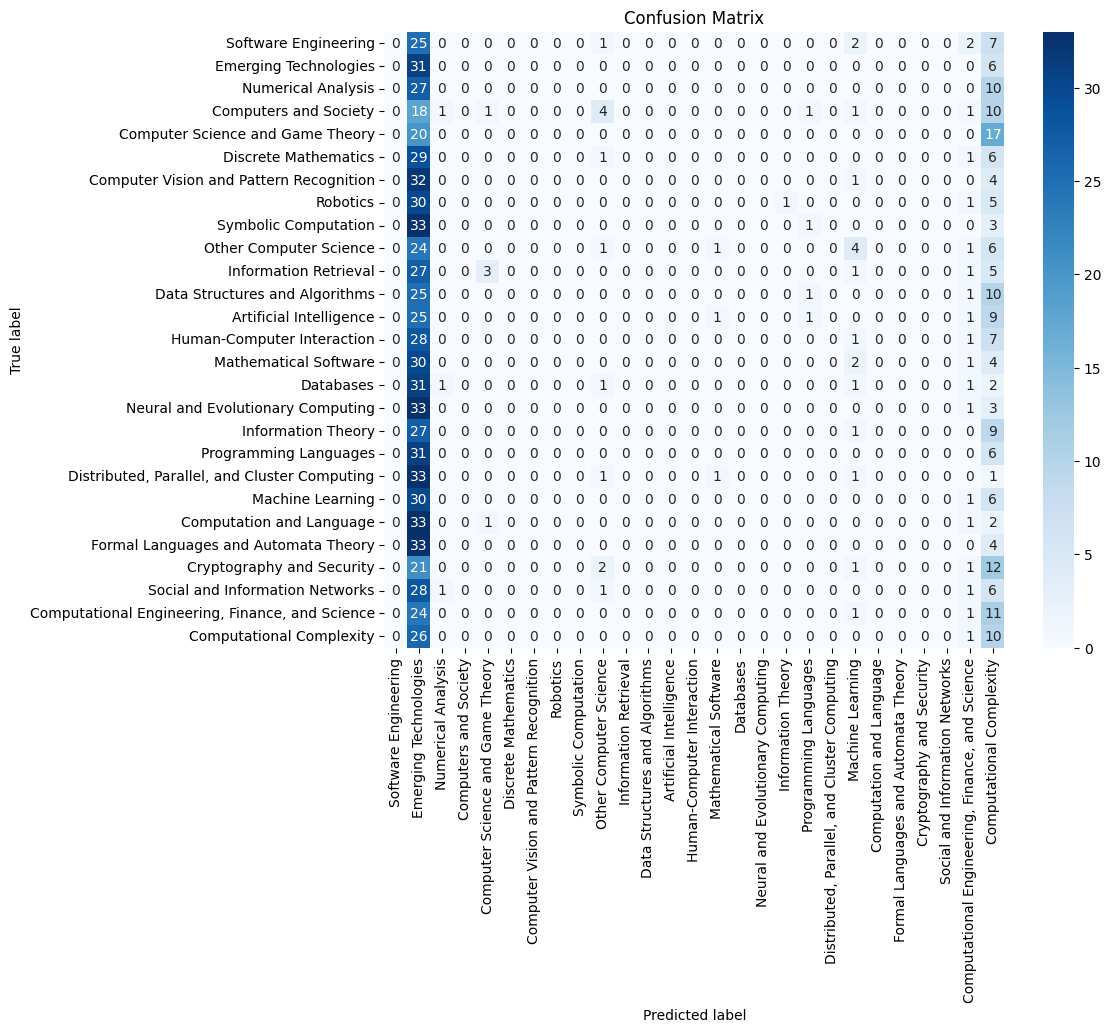

In [ ]:
cm = confusion_matrix(balanced_sample['first_category_english'], balanced_sample['first_cat_pred_abstract_desc'])

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))

# Rotate the x-axis labels vertically
plt.xticks(rotation=90)

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')

plt.show()

In [ ]:
def classify_title_desc(batch, col_name='first_cat_pred_title_desc'):
    result = pipe(batch['title'], candidate_labels=list(categories_dict.values()))
    prediction = result['labels'][0]
    batch[col_name] = swapped_categories[prediction]
    return batch  # Return the label with the highest score
balanced_sample = balanced_sample.map(classify_title_desc)

Map:   0%|          | 0/999 [00:00<?, ? examples/s]

In [ ]:
balanced_sample = balanced_sample.map(lambda x: {'first_cat_pred_title_desc': label_mapping[x['first_cat_pred_title_desc']]})
accuracy = accuracy_score(balanced_sample['first_category_english'], balanced_sample['first_cat_pred_title_desc'])
f1 = f1_score(balanced_sample['first_category_english'], balanced_sample['first_cat_pred_title_desc'], average='weighted')
print("Accuracy:", accuracy)
print("F1 score", f1)

Map:   0%|          | 0/999 [00:00<?, ? examples/s]

Accuracy: 0.03803803803803804
F1 score 0.004780429964774831


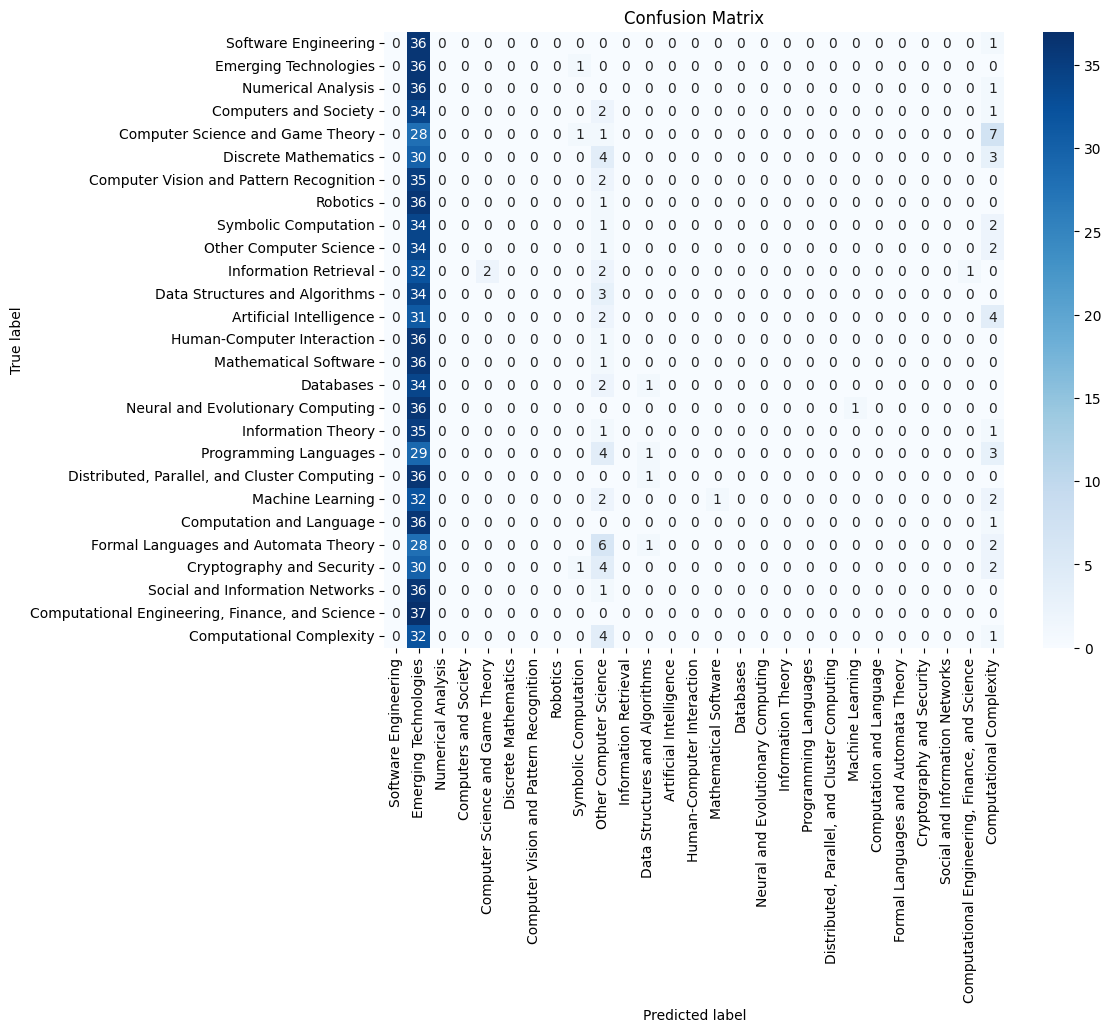

In [ ]:
cm = confusion_matrix(balanced_sample['first_category_english'], balanced_sample['first_cat_pred_title_desc'])

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))

# Rotate the x-axis labels vertically
plt.xticks(rotation=90)

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')

plt.show()

Written answers: The model performed worse at classifying categories using the long and detailed descriptions as labels. The use of long and detailed labels increases the complexity of the task. This additional complexity combined with the limited information in abstract and title make the model unable to capture any patterns. As a result, the model does not know how to map the context in to the detailed description, leading to unaccurate prediction.